In [12]:
# ✅ Importações necessárias
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt

In [13]:
# ✅ Função para rodar ICP com Open3D
def run_icp_open3d(source_np, target_np, threshold=1.0, init=np.eye(4), max_iter=50):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_np)
    
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_np)

    reg = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter)
    )
    return reg.transformation

In [14]:
def run_icp_open3d(source_np, target_np, threshold=1.0, init=np.eye(4), max_iter=50):
    # Converte numpy para PointCloud
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_np)

    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_np)

    # ✅ Estima as normais para ambos (obrigatório para Point-to-Plane)
    source.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
    target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

    # ✅ Troca para estimador Point-to-Plane
    reg = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter)
    )

    return reg.transformation


In [15]:
def run_icp_open3d(source_np, target_np, threshold=1.0, init=np.eye(4), max_iter=50, method='plane'):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_np)
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_np)

    if method == 'plane':
        source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
        target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
        estimation = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    else:
        estimation = o3d.pipelines.registration.TransformationEstimationPointToPoint()

    reg = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init,
        estimation,
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter)
    )
    return reg.transformation


In [16]:
# ✅ Função best_fit_transform para alinhar trajetórias
def best_fit_transform(A, B):
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B
    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = centroid_B.T - R @ centroid_A.T
    return R, t.reshape(3,1)

In [17]:
# ✅ Carregando arquivos
import trimesh
kitti_dataset = '..\dtLabs\KITTI-Sequence'  # <-- altere para seu caminho real
gt_path = '..\dtLabs\ground_truth.npy'      # <-- altere para seu caminho real

point_clouds = []
for root, _, files in os.walk(kitti_dataset):
    for file in sorted(files):
        if file.endswith('.obj'):
            mesh = trimesh.load(os.path.join(root, file))
            vertices = np.asarray(mesh.vertices)
            point_clouds.append(vertices)

ground_truth = np.load(gt_path)

In [18]:
# ✅ Rodando ICP e construindo a trajetória
trajectory = [np.eye(4)]

for i in range(len(point_clouds) - 1):
    A = point_clouds[i]
    B = point_clouds[i + 1]
    T = run_icp_open3d(A, B, threshold=1.0, max_iter=50)
    T_absolute = trajectory[-1] @ T
    trajectory.append(T_absolute)

In [19]:
# ✅ Alinhando com Ground Truth
icp_estimated = np.array([T[:3, 3] for T in trajectory])
gt_positions = np.array([gt[:3, 3] for gt in ground_truth[:len(icp_estimated)]])

R_init, t_init = best_fit_transform(icp_estimated, gt_positions)
icp_estimated_aligned = [(R_init @ p.reshape(3, 1) + t_init).flatten() for p in icp_estimated]
icp_estimated_aligned = np.array(icp_estimated_aligned)

# Corrige origem
offset = gt_positions[0] - icp_estimated_aligned[0]
icp_estimated_aligned += offset

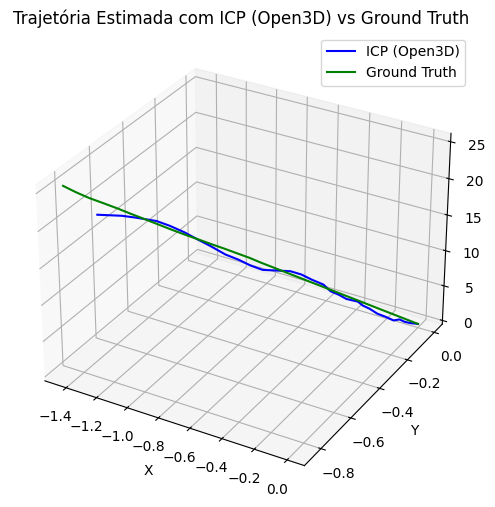

In [20]:
# ✅ Plotando
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(icp_estimated_aligned[:, 0], icp_estimated_aligned[:, 1], icp_estimated_aligned[:, 2],
        label='ICP (Open3D)', color='blue')
ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2],
        label='Ground Truth', color='green')

ax.set_title('Trajetória Estimada com ICP (Open3D) vs Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()